In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import functools

# TI-03: Quantum Hall Effect
In this exercise, we will build on [TB_07](../TB_07/run.ipynb) and [A_03](../A_03/run.ipynb) to simulate the quantum hall effect. In A_03, we learned how to created a hall bar device and in TB_07 how to deal with magnetic fields.

Here, we will extract the Hall resistance from the transmissions calculated with TBTrans using the Landauer-Büttiker formalism.

## Exercise Overview:
1. Create a Hall bar (see [A_03](../A_03/run.ipynb))
2. Construct Hamiltonians and add magnetic fields (see [TB_07](../TB_07/run.ipynb))
3. Calculate the transmission with `TBtrans`
4. Extract the Hall resistance $(R_H)$.

## Exercise

### 1. Create a Hall bar
In order to be able to observe the quantum hall effect, the size of the hall bar needs to be big enough. For a 4(6) lead device reasonable dimensions are: 
1. 4-lead device:
   - Width of electrodes (perpendicular to the semi-infinite axis): 30 atoms
   - Offset of the electrodes 2(3) from the corner of the central part: >= 5 atoms


2. 6-lead device: 
   - Width of electrodes (perpendicular to the semi-infinite axis): 30 atoms
   - Spacing between electrodes on the same side: 50 atoms
   - Offset of the electrodes 2(3,5,6) from the corner of the central part: > 15 atoms

|4-lead device |6-lead device |
|:-------------|:-------------|
|<img src="img/set-up-4.png" alt="4 lead hall bar" style="width: 310px;"/>|<img src="img/set-up-6.png" alt="6 lead hall bar" style="width: 490px;"/>|
   



In [2]:
sq = sisl.Geometry([.5] * 3,
                   sisl.Atom(1, R=1.),
                   sc=sisl.SuperCell([1., 1., 10.], nsc=[3, 3, 1]))

In [3]:
el_width = 30 # Width of the electrode (perpendicular to semi-inf. direction)
el_length = 1 # Length of the electrode (in the semi-inf. direction)
el_offx = 25  # Offset along x-axis of electrodes from the corners of the device 
el_offy = 0   # Offset along y-axis of electrodes from the corners of the device
el_pad = 50   # Distance between electrodes (only for 6-lead device)


el_x = sq.tile(el_width, 1).tile(el_length, 0)
el_y = sq.tile(el_width, 0).tile(el_length, 1)

#### 4-lead device

In [4]:
nx = 1 * el_width + 2 * el_offx
ny = 1 * el_width + 2 * el_offy
center = sq.tile(nx, 0).tile(ny, 1)

# Create space for the electrode regions
dev = center.prepend(el_x.sc, axis=0).prepend(el_x.sc, axis=0)
dev = dev.prepend(el_y.sc, axis=1).prepend(el_y.sc, axis=1)
dev = dev.move(el_x.cell[0]+el_y.cell[1])

# These help find atomic indices by their grid position
dev_idx = np.arange(dev.no).reshape((nx,ny), order='F')
el_x_idx = np.arange(el_x.no).reshape((el_length, el_width), order='C')
el_y_idx = np.arange(el_y.no).reshape((el_width, el_length), order='F')

# Attach the electrodes
print("1) Elec.Left\n\t electrode-position", dev.no+1)
dev = dev.attach(dev_idx[0,el_offy], el_x, el_x_idx[-1,0], dist=[-1,0,0])

print("2) Elec.Bottom\n\t  electrode-position", dev.no+1)
dev = dev.attach(dev_idx[el_offx, 0], el_y, el_y_idx[0,-1], dist=[0,-1,0])

dev = dev.attach(dev_idx[el_offx, -1], el_y, el_y_idx[0,0], dist=[0,1,0])
print("3) Elec.Top\n\t  electrode-position end", dev.no)

dev = dev.attach(dev_idx[-1,el_offy], el_x, el_x_idx[0,0], dist=[1,0,0])
print("4) Elec.Right\n\t  electrode-position end", dev.no)

dev_final = dev

1) Elec.Left
	 electrode-position 2401
2) Elec.Bottom
	  electrode-position 2431
3) Elec.Top
	  electrode-position end 2490
4) Elec.Right
	  electrode-position end 2520


#### 6-lead device

In [5]:
nx = 2 * el_width + 1 * el_pad + 2 * el_offx
ny = 1 * el_width + 2 * el_offy
center = sq.tile(nx, 0).tile(ny, 1)

# Create space for the electrode regions
dev = center.prepend(el_x.sc, axis=0).prepend(el_x.sc, axis=0)
dev = dev.prepend(el_y.sc, axis=1).prepend(el_y.sc, axis=1)
dev = dev.move(el_x.cell[0]+el_y.cell[1])

# These help find atomic indices by their grid position
dev_idx = np.arange(dev.no).reshape((nx,ny), order='F')
el_x_idx = np.arange(el_x.no).reshape((el_length, el_width), order='C')
el_y_idx = np.arange(el_y.no).reshape((el_width, el_length), order='F')

# Attach the electrodes
print("1) Elec.Left\n\t  electrode-position", dev.no+1)
dev = dev.attach(dev_idx[0,el_offy], el_x, el_x_idx[-1,0], dist=[-1,0,0])

print("2) Elec.BottomLeft\n\t  electrode-position", dev.no+1)
dev = dev.attach(dev_idx[el_offx, 0], el_y, el_y_idx[0,-1], dist=[0,-1,0])

print("3) Elec.BottomRight\n\t  electrode-position", dev.no+1)
dev = dev.attach(dev_idx[-1-el_offx, 0], el_y, el_y_idx[-1,-1], dist=[0,-1,0])

dev = dev.attach(dev_idx[-1,el_offy], el_x, el_x_idx[0,0], dist=[1,0,0])
print("4) Elec.Right\n\t  electrode-position end", dev.no)

dev = dev.attach(dev_idx[-1-el_offx, -1], el_y, el_y_idx[-1,0], dist=[0,1,0])
print("5) Elec.TopRight\n\t  electrode-position end", dev.no)

dev = dev.attach(dev_idx[el_offx, -1], el_y, el_y_idx[0,0], dist=[0,1,0])
print("6) Elec.TopLeft\n\t  electrode-position end", dev.no)

dev_final = dev

1) Elec.Left
	  electrode-position 4801
2) Elec.BottomLeft
	  electrode-position 4831
3) Elec.BottomRight
	  electrode-position 4861
4) Elec.Right
	  electrode-position end 4920
5) Elec.TopRight
	  electrode-position end 4950
6) Elec.TopLeft
	  electrode-position end 4980


### 2. Construct Hamiltonian and add magnetic fields

The required field strengths may vary depending on the size of the hall bar.
A good starting point might by `B = 1 / np.arange(1,31)`

In [6]:
def peierls(self, ia, atoms, atoms_xyz=None, B=None):
    idx = self.geometry.close(ia, R=[0.1, 1.01], atoms=atoms, atoms_xyz=atoms_xyz)
    # Onsite
    self[ia, idx[0]] = 4
    
    # Hopping
    if B == 0:
        self[ia, idx[1]] = -1
    else:
        xyz = self.geometry.xyz[ia]
        dxyz = self.geometry[idx[1]]
        self[ia, idx[1]] = - np.exp(-0.5j * B * (dxyz[:, 0] - xyz[0])*(dxyz[:,1] + xyz[1]))

In [7]:
# Create hamiltonian for the electrodes
H_el = sisl.Hamiltonian(el_x, dtype=np.float64)
H_el.set_nsc([3,1,1])
H_el.construct(functools.partial(peierls, B=0.))
H_el.write('ELEC_x.nc')

H_el = sisl.Hamiltonian(el_y, dtype=np.float64)
H_el.set_nsc([1,3,1])
H_el.construct(functools.partial(peierls, B=0.))
H_el.write('ELEC_y.nc')

In [8]:
# Create device hamiltonian without magnetic field
H_dev = sisl.Hamiltonian(dev_final, dtype=np.float64)
H_dev.set_nsc([1,1,1])
H_dev.construct(functools.partial(peierls, B=0))
H_dev.write('DEVICE.nc')

In [9]:
# Calculate device hamiltonian with magnetic field and store dH
dH = sisl.Hamiltonian(dev_final, dtype=np.complex128)
dH.set_nsc([1,1,1])

# Rec_phis: reciprocal phis, reciprocal mesh is advantages because steps scale with 1/B and phi ~ B
rec_phis = np.linspace(10,30,21)
for rec_phi in rec_phis:
    dH.construct(functools.partial(peierls, B=1/rec_phi))
    dH = dH - H_dev
    with sisl.get_sile('M_{}.dH.nc'.format(rec_phi), mode='w') as fh:
        fh.write_delta(dH)

In [10]:
# plt.figure(figsize=(4,4), dpi=400)
# plt.imshow(dH.Hk(format='array').imag, interpolation='None')
# plt.colorbar()

### 3. Calculate the transmission with TBtrans

The folder of this exercise contains the skeleton of an input file for a 4-lead (RUN-4.fdf) and 6-lead device (RUN-6.fdf), as well as a script to run TBtrans for all values of the magnetic field (run.sh).

*Depending on the size of the Hall bar this step might require some a considerable amount of time.*

### 4. Extract the Hall resistance $(R_H)$

The Hall resistance ($R_H$) in a 4 lead Hall bar like the one shown above is given by

$$R_H = \left.\frac{V_2-V_3}{I_1}\right|_{I_2 = I_3 = 0}.$$

In order to find a relationship between the transmission curves and the hall resistance, we express the lead currents $I_i$ in terms of applied biases $V_i$ and the transmissions $T_{ij}$ between leads $i$ and $j$
$$I_i = \sum_j G_{ij} (V_i - V_j)\quad\text{where}\quad G_{ij} = \frac{2e^2}{h} T_{ij}.$$
Since the currents only depend on bias differences, we can set one of them to zero without loss of generality (here $V_3 = 0$). This allows us to rewrite the relation as

$$\mathbf{I} = \mathcal{G} \mathbf{V}
\quad\text{, where}\quad
\mathcal{G}_{ii} = \sum_{i\neq j} G_{ij}
\quad\text{and}\quad
\mathcal{G}_{ij} = - G_{ij}.$$

Using the inverse $\mathbf{R}$ of $\mathcal{G}$, we can express $V_2$ and $V_3$ in terms of the lead currents $I_i$ and calculate the Hall conductance:

$$
V_i = R_{i1} I_1 + R_{i2} I_2 + R_{i3} I_3,
$$
and finally, we find the Hall resistance:
$$
R_H = R_{21}-R_{31}
$$

The derivation for the 6-lead device is analogous and yields:
$$
R_H = R_{21}-R_{61}
$$

In [11]:
# Create short-hand function
gs = sisl.get_sile
# No magnetic field
tbt0 = gs('M_0/siesta.TBT.nc')
# All magnetic fields in increasing order
tbts = [gs('M_{}/siesta.TBT.nc'.format(rec_phi)) for rec_phi in rec_phis]

In [12]:
# Create matrix G
def Tmatrix (tbtsile, n, E_idx, ref_idx):
    mT = np.zeros((E_idx, n, n))
    for i in range(n):
        for j in range(n):
            if i == j: continue
            Tij = tbtsile.transmission(i,j)
            mT[:,i,j] = -Tij
            mT[:,i,i] += Tij
    return np.delete(np.delete(mT, ref_idx, axis=2), ref_idx, axis=1)

E = tbt0.E
n, E_idx, ref_idx = 6, E.shape[0], 2
T0 = Tmatrix(tbt0, n, E_idx, ref_idx)

T = np.zeros((len(rec_phis), E_idx, n-1, n-1))
for i, tbt in enumerate(tbts):
    T[i] = Tmatrix(tbt, n, E_idx, ref_idx)

In [13]:
# Calculate inverse of G
R0 = np.linalg.inv(T0)
R = []
for i in range(len(rec_phis)):
    try:
        R.append(np.linalg.inv(T[i]))
    except np.linalg.LinAlgError:
        R.append(np.zeros((E.shape[0], n-1, n-1)))
        
R = np.asarray(R)

# Extract RH (and longitudial resistance for 6-lead device (R_L))
RH = R0[:,1,0] - R0[:,2,0]
RL = R0[:,1,0] - R0[:,2,0]
RH = R[:,:,1,0] - R[:,:,2,0]
RL = R[:,:,1,0] - R[:,:,1,0]

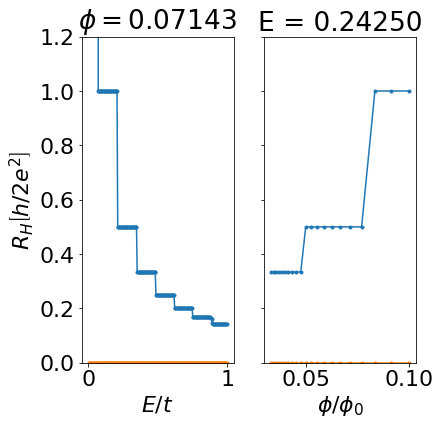

In [14]:
# Plot the results
E_idx = 48
phi_idx = 4
plt.rcParams.update({'font.size':22})
fig, axs = plt.subplots(1,2, sharey=True, figsize=(6,6))#, dpi=300)
axs[0].set_title('$\phi = {:.5f}$'.format(1/rec_phis[phi_idx]))
axs[0].plot(E, RH[phi_idx,:], '.-')
axs[0].plot(E, RL[phi_idx,:], '.-')
axs[0].set_ylim(0,1.2)
axs[0].set_ylabel(r'$R_H \left[h/2e^2\right]$')
axs[0].set_xlabel('$E/t$')
axs[1].set_title(f'E = {E[E_idx]:.5f}')
axs[1].plot(1/rec_phis, RH[:,E_idx], '.-')
axs[1].plot(1/rec_phis, RL[:,E_idx], '.-')
axs[1].set_xlabel('$\phi/\phi_0$')
plt.show()